In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [2]:
index = pd.date_range("2021-09-01", periods=2400, freq="1h")
df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
ddf = dd.from_pandas(df, npartitions=10)
ddf

,a,b
npartitions=10,,
2021-09-01 00:00:00,int64,string
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [3]:
display(ddf.divisions)
ddf.partitions[1]

(Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-09-11 00:00:00'),
 Timestamp('2021-09-21 00:00:00'),
 Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-10-11 00:00:00'),
 Timestamp('2021-10-21 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-09 23:00:00'))

,a,b
npartitions=1,,
2021-09-11,int64,string
2021-09-21,...,...


In [4]:
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100
display(result)

result.compute()

Dask Series Structure:
npartitions=1
2021-10-01 00:00:00.000000000    int64
2021-10-09 05:00:59.999999999      ...
Dask Name: sub, 5 expressions
Expr=CumSum(frame=(LocSlice(frame=df, iindexer=slice(Timestamp('2021-10-01 00:00:00'), Timestamp('2021-10-09 05:00:59.999999999'), None)))['a'], skipna=True) - 100

2021-10-01 00:00:00       620
2021-10-01 01:00:00      1341
2021-10-01 02:00:00      2063
2021-10-01 03:00:00      2786
2021-10-01 04:00:00      3510
                        ...  
2021-10-09 01:00:00    158301
2021-10-09 02:00:00    159215
2021-10-09 03:00:00    160130
2021-10-09 04:00:00    161046
2021-10-09 05:00:00    161963
Freq: h, Name: a, Length: 198, dtype: int64

{('sub-eebc03bb5505dfb07416b4fbd92d5139',
  0): <Task ('sub-eebc03bb5505dfb07416b4fbd92d5139', 0) sub(...)>,
 ('cumulativefinalize-c84b0f8ecf10f71d230544539f044652',
  0): ('cumsum-e20fcbf6c4d8eda775020e3b7c4b791d', 0),
 ('operation-aacd21d2599cdd1704dfcf208f8222e1',
  0): <Task ('operation-aacd21d2599cdd1704dfcf208f8222e1', 0) operation(...)>,
 ('cumsum-e20fcbf6c4d8eda775020e3b7c4b791d',
  0): <Task ('cumsum-e20fcbf6c4d8eda775020e3b7c4b791d', 0) cumsum(...)>,
 ('getitem-b30cd0817323990ef9ce62e05e218713',
  0): <Task ('getitem-b30cd0817323990ef9ce62e05e218713', 0) getitem(...)>,
 ('loc-efb1c1846e6ebd78444b69ffc82fcb86',
  0): <Task ('loc-efb1c1846e6ebd78444b69ffc82fcb86', 0) loc(...)>,
 ('partitions-16166c71926eb3bb0e9da95b33a1c035',
  0): Alias(('partitions-16166c71926eb3bb0e9da95b33a1c035', 0)->('frompandas-33946d5e46faffe611c6bc08f15bacda', 3)),
 ('frompandas-33946d5e46faffe611c6bc08f15bacda',
  0): DataNode(                       a  b
 2021-09-01 00:00:00    0  a
 2021-09-01 01:00:

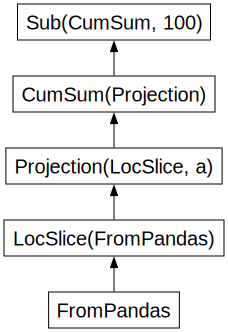

In [5]:
display(result.dask)
result.visualize()

In [6]:
import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet

c = c.compute()  # This triggers all of the above computations
c

5

In [7]:
from dask.distributed import Client

client = Client()
display(client)

def inc(x):
   return x + 1

def add(x, y):
   return x + y

a = client.submit(inc, 1)     # work starts immediately
b = client.submit(inc, 2)     # work starts immediately
c = client.submit(add, a, b)  # work starts immediately

c = c.result()                # block until work finishes, then gather resul
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51588,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.78 GiB
Comm: tcp://127.0.0.1:51608,Total threads: 4
Dashboard: http://127.0.0.1:51611/status,Memory: 7.94 GiB
Nanny: tcp://127.0.0.1:51591,


5

In [8]:
client.close()

In [17]:
from dask_kubernetes.operator import KubeCluster

cluster = KubeCluster(name="my-dask", namespace="dask")

In [18]:
cluster

Dashboard: http://localhost:59502/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.1.50:8786,Workers: 0
Dashboard: http://10.42.1.50:8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [19]:
client = Client(cluster)
client

c:\Users\olive\git\dask\.venv\Lib\site-packages\distributed\client.py:1612: VersionMismatchWarning: Mismatched versions found

+---------+----------------+-----------------+---------+
| Package | Client         | Scheduler       | Workers |
+---------+----------------+-----------------+---------+
| lz4     | 4.4.3          | 4.3.3           | None    |
| python  | 3.13.2.final.0 | 3.10.12.final.0 | None    |
| toolz   | 1.0.0          | 0.12.0          | None    |
+---------+----------------+-----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_kubernetes.KubeCluster
Dashboard: http://localhost:59502/status,
Dashboard: http://localhost:59502/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.1.50:8786,Workers: 0
Dashboard: http://10.42.1.50:8787/status,Total threads: 0
Started: 2 minutes ago,Total memory: 0 B


In [31]:
cluster.adapt(minimum=1, maximum=10)

In [ ]:
INPUT_CSV_PATH = '5000000 HRA Records.csv'
OUTPUT_PARQUET_PATH = '5000000 HRA Records'

# Define the column data types
DTYPES = {
    'Age': 'int64',
    'Attrition': 'object',
    'BusinessTravel': 'object',
    'DailyRate': 'int64',
    'Department': 'object',
    'DistanceFromHome': 'int64',
    'Education': 'int64',
    'EducationField': 'object',
    'EmployeeCount': 'int64',
    'EmployeeNumber': 'int64',
    'EnvironmentSatisfaction': 'int64',
    'Gender': 'object',
    'HourlyRate': 'int64',
    'JobInvolvement': 'int64',
    'JobLevel': 'int64',
    'JobRole': 'object',
    'JobSatisfaction': 'int64',
    'MaritalStatus': 'object',
    'MonthlyIncome': 'int64',
    'MonthlyRate': 'int64',
    'NumCompaniesWorked': 'int64',
    'Over18': 'object',
    'OverTime': 'object',
    'PercentSalaryHike': 'int64',
    'PerformanceRating': 'int64',
    'RelationshipSatisfaction': 'int64',
    'StandardHours': 'int64',
    'StockOptionLevel': 'int64',
    'TotalWorkingYears': 'int64',
    'TrainingTimesLastYear': 'int64',
    'WorkLifeBalance': 'int64',
    'YearsAtCompany': 'int64',
    'YearsInCurrentRole': 'int64',
    'YearsSinceLastPromotion': 'int64',
    'YearsWithCurrManager': 'int64'
}

# Read the CSV file in streaming mode using Dask with specified dtypes and block size
dask_df = dd.read_csv(INPUT_CSV_PATH, dtype=DTYPES, blocksize="100MB")

# Perform any data transformations here (e.g., filtering, renaming, etc.)
# Example: dask_df = dask_df[dask_df["some_column"] > 10]

# Write the data to a Parquet file efficiently using pyarrow
dask_df.to_parquet(OUTPUT_PARQUET_PATH, engine='pyarrow')

RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments
